# Forecasting with covariates on synthetic data

In [13]:
N_TIMESTEPS = 1000
N_TRAIN_TIMESTEPS = int(N_TIMESTEPS * 0.6)
PERIOD = [6, 12, 24, 48]
FEATURE_PERIOD = [96]

## Data Generation

In [14]:
import numpy as np
import matplotlib.pyplot as plt


def generate_synthetic_data(
    n_series=100,
    n_timesteps=200,
    n_covariates=3,
    seasonality_periods=[7, 30],
    trend_strength=0.1,
    noise_level=0.1,
    covariate_impact=0.5,
    seed=42,
):
    np.random.seed(seed)
    all_series = np.zeros((n_series, n_timesteps))
    all_covariates = np.zeros((n_series, n_covariates, n_timesteps))
    all_covariate_weights = np.zeros((n_series, n_covariates))
    all_raw_series = np.zeros((n_series, n_timesteps))

    for i in range(n_series):
        covariates = np.zeros((n_covariates, n_timesteps))
        for j in range(n_covariates):
            pattern_type = np.random.choice(["sinusoidal", "step", "random_walk"])
            if pattern_type == "sinusoidal":
                period = np.random.randint(50, 100)
                phase = np.random.uniform(0, 2 * np.pi)
                covariates[j] = np.sin(
                    2 * np.pi * np.arange(n_timesteps) / period + phase
                )
            elif pattern_type == "step":
                n_steps = np.random.randint(2, 5)
                step_times = np.sort(
                    np.random.choice(n_timesteps, n_steps, replace=False)
                )
                step_values = np.random.normal(0, 1, n_steps)
                for k in range(n_steps):
                    start_idx = step_times[k]
                    end_idx = step_times[k + 1] if k < n_steps - 1 else n_timesteps
                    covariates[j, start_idx:end_idx] = step_values[k]
            else:  # random_walk
                covariates[j] = np.cumsum(np.random.normal(0, 0.1, n_timesteps))
            covariates[j] = (covariates[j] - np.mean(covariates[j])) / np.std(
                covariates[j]
            )

        trend = np.linspace(0, trend_strength * np.random.normal(0, 1), n_timesteps)
        seasonality = np.zeros(n_timesteps)
        for period in seasonality_periods:
            if period < n_timesteps:
                amplitude = np.random.uniform(0.1, 0.5)
                phase = np.random.uniform(0, 2 * np.pi)
                seasonality += amplitude * np.sin(
                    2 * np.pi * np.arange(n_timesteps) / period + phase
                )

        covariate_weights = np.random.normal(0, 1, n_covariates)
        covariate_effect = np.zeros(n_timesteps)
        for j in range(n_covariates):
            covariate_effect += covariate_weights[j] * covariates[j]

        # Noisy series
        noise = np.random.normal(0, noise_level, n_timesteps)
        raw_series = trend + seasonality + noise
        series_w_cov = raw_series + covariate_impact * covariate_effect

        all_series[i] = series_w_cov
        all_raw_series[i] = raw_series
        all_covariates[i] = covariates
        all_covariate_weights[i] = covariate_weights

    return {
        "target": all_series,
        "target_raw": all_raw_series,
        "covariates": all_covariates,
        "covariate_weights": all_covariate_weights,
    }

In [15]:
from abc import ABC, abstractmethod


class CovariateGenerator(ABC):
    @abstractmethod
    def generate(self, n_timesteps: int) -> np.ndarray:
        pass


class SinusoidalCovariate(CovariateGenerator):
    def __init__(self, period: int, phase: float):
        self.period = period
        self.phase = phase

    def generate(self, n_timesteps: int) -> np.ndarray:
        return np.sin(2 * np.pi * np.arange(n_timesteps) / self.period + self.phase)


class LinearTrendCovariate(CovariateGenerator):
    def __init__(self, slope: float):
        self.slope = slope

    def generate(self, n_timesteps: int) -> np.ndarray:
        return self.slope * np.arange(n_timesteps)


class RandomWalkCovariate(CovariateGenerator):
    def __init__(
        self,
        step_size: float,
        interval: int = 1,
        interpolation_method: str = "constant",  # "constant" or "linear"
    ):
        self.step_size = step_size
        self.interval = interval
        self.interpolation_method = interpolation_method

    def generate(self, n_timesteps: int) -> np.ndarray:
        # Generate random walk with steps every interval timesteps
        n_steps = (n_timesteps + self.interval - 1) // self.interval
        steps = np.random.normal(0, self.step_size, n_steps)
        walk_values = np.cumsum(steps)

        # Interpolate to fill all timesteps
        if self.interpolation_method == "constant":
            # Step interpolation - hold value constant within each interval
            result = np.zeros(n_timesteps)
            for i in range(n_timesteps):
                step_index = min(i // self.interval, len(walk_values) - 1)
                result[i] = walk_values[step_index]
        elif self.interpolation_method == "linear":
            # Linear interpolation between interval points
            interval_points = np.arange(0, n_timesteps, self.interval)
            if len(interval_points) > len(walk_values):
                # Pad walk_values if needed
                walk_values = np.pad(
                    walk_values,
                    (0, len(interval_points) - len(walk_values)),
                    mode="edge",
                )
            elif len(interval_points) < len(walk_values):
                # Truncate walk_values if needed
                walk_values = walk_values[: len(interval_points)]

            # Add final point if needed for interpolation
            if interval_points[-1] < n_timesteps - 1:
                interval_points = np.append(interval_points, n_timesteps - 1)
                walk_values = np.append(walk_values, walk_values[-1])

            result = np.interp(np.arange(n_timesteps), interval_points, walk_values)
        else:
            raise ValueError(
                f"Unknown interpolation method: {self.interpolation_method}"
            )

        return result


class SparsePositiveOnlySinusoidalCovariate(CovariateGenerator):
    def __init__(self, period: int, phase: float):
        self.period = period
        self.phase = phase

    def generate(self, n_timesteps: int) -> np.ndarray:
        sinusoid = SinusoidalCovariate(period=self.period, phase=self.phase).generate(
            n_timesteps
        )

        for window in range(0, n_timesteps, self.period):
            if np.random.rand() > 0.5:
                sinusoid[window : window + self.period] = 0

        mask = sinusoid > 0

        return sinusoid * mask


class StepChangeCovariate(CovariateGenerator):
    def __init__(self, n_changes: int = 3, change_magnitude: float = 1.0):
        """
        Generate a covariate with discrete step changes at random points.

        Args:
            n_changes: Number of step changes to introduce
            change_magnitude: Magnitude of each step change
        """
        self.n_changes = n_changes
        self.change_magnitude = change_magnitude

    def generate(self, n_timesteps: int) -> np.ndarray:
        result = np.zeros(n_timesteps)

        # Generate random change points
        if self.n_changes > 0:
            change_points = np.sort(
                np.random.choice(
                    np.arange(1, n_timesteps),
                    size=min(self.n_changes, n_timesteps - 1),
                    replace=False,
                )
            )

            current_level = 0.0
            last_point = 0

            for change_point in change_points:
                # Fill from last point to this change point
                result[last_point:change_point] = current_level

                # Apply random step change
                step = np.random.choice([-1, 1]) * self.change_magnitude
                current_level += step
                last_point = change_point

            # Fill remainder with final level
            result[last_point:] = current_level

        return result


class RandomStepChangeCovariate(CovariateGenerator):
    def __init__(
        self, n_changes_low: int, n_changes_high: int, change_magnitude: float
    ):
        self.n_changes_low = n_changes_low
        self.n_changes_high = n_changes_high
        self.change_magnitude = change_magnitude

    def generate(self, n_timesteps: int) -> np.ndarray:
        n_changes = np.random.randint(self.n_changes_low, self.n_changes_high + 1)
        return StepChangeCovariate(
            n_changes=n_changes, change_magnitude=self.change_magnitude
        ).generate(n_timesteps)

### Raw Data Generation

In [16]:
def generate_raw_data(
    n_series: int = 1,
    n_timesteps: int = 240,
    seasonality_periods: list[int] | int = [24],
    seed: int = 0,
) -> np.ndarray:
    if isinstance(seasonality_periods, int):
        seasonality_periods = [seasonality_periods]

    np.random.seed(seed)
    all_series = np.zeros((n_series, n_timesteps))
    for i in range(n_series):
        series = np.zeros(n_timesteps)
        for period in seasonality_periods:
            series += np.sin(2 * np.pi * np.arange(n_timesteps) / period)
        all_series[i] = series

    return all_series

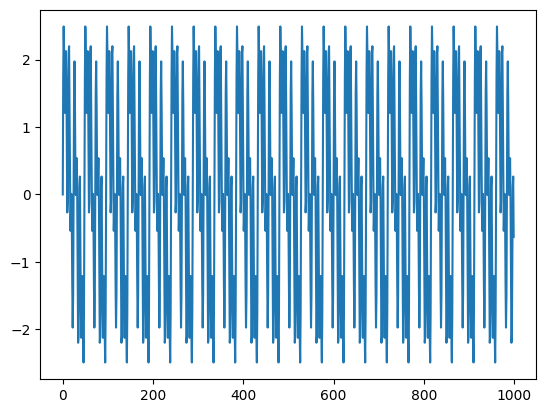

In [17]:
raw_data = generate_raw_data(
    n_series=1,
    n_timesteps=N_TIMESTEPS,
    seasonality_periods=PERIOD,
    seed=0,
).squeeze()

plt.plot(raw_data)
plt.show()

In [18]:
def transform_with_covariate(
    x: np.ndarray,
    covariate: np.ndarray,
    relation: str,
    weight: float,
) -> np.ndarray:
    if relation == "additive":
        return x + weight * covariate
    elif relation == "multiplicative":
        return x * weight * covariate
    else:
        raise ValueError(f"Invalid relation: {relation}")

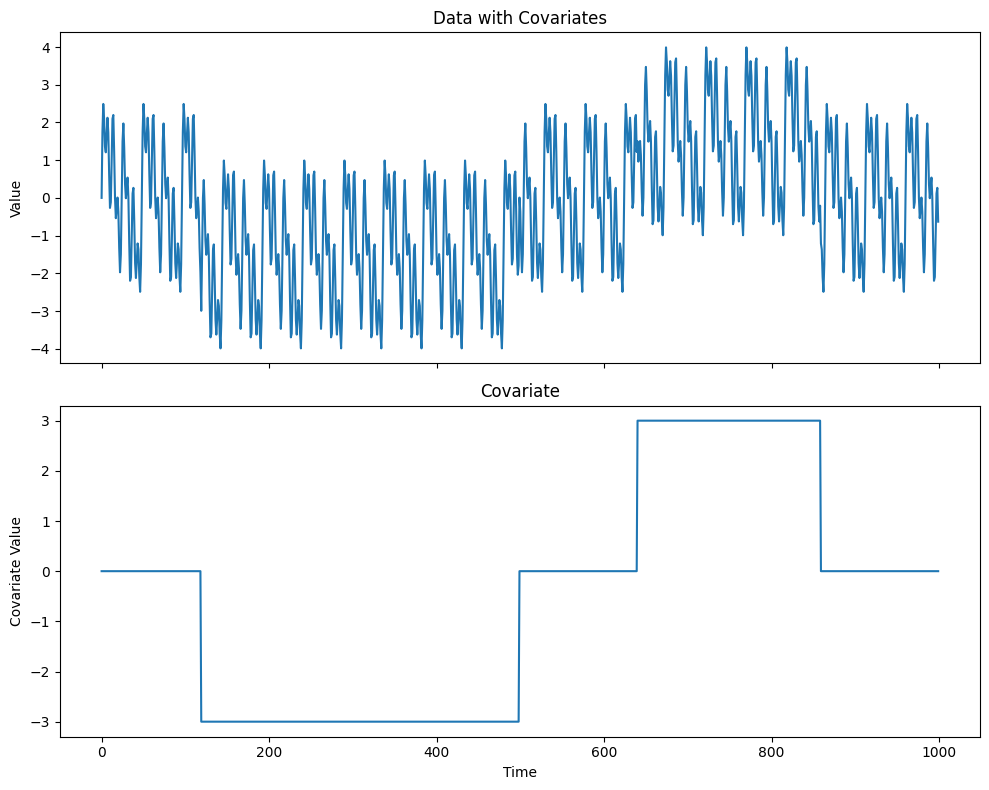

In [26]:
import numpy as np
import matplotlib.pyplot as plt

linear_trend_covar = LinearTrendCovariate(slope=0.1).generate(N_TIMESTEPS)
sinusoidal_covar = SinusoidalCovariate(period=11, phase=5).generate(N_TIMESTEPS) * 5
sparse_positive_only_sinusoidal_covar = (
    SparsePositiveOnlySinusoidalCovariate(period=29, phase=0).generate(N_TIMESTEPS) * 3
)
random_walk_covar = RandomWalkCovariate(
    step_size=2, interval=10, interpolation_method="linear"
).generate(N_TIMESTEPS)

# covariate = sinusoidal_covar
# covariate = linear_trend_covar
# covariate = sparse_positive_only_sinusoidal_covar
# covariate = random_walk_covar
# covariate = StepChangeCovariate(n_changes=3, change_magnitude=1.0).generate(N_TIMESTEPS) * 3
covariate = (
    RandomStepChangeCovariate(
        n_changes_low=3, n_changes_high=5, change_magnitude=1.0
    ).generate(N_TIMESTEPS)
    * 3
)
# covariate = np.zeros(N_TIMESTEPS)

data_w_covariates = transform_with_covariate(
    raw_data,
    covariate=covariate,
    relation="additive",
    # relation='multiplicative',
    weight=0.5,
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.plot(data_w_covariates)
ax1.set_title("Data with Covariates")
ax1.set_ylabel("Value")

ax2.plot(covariate)
ax2.set_title("Covariate")
ax2.set_ylabel("Covariate Value")
ax2.set_xlabel("Time")

plt.tight_layout()
plt.show()

## Featurization

In [20]:
x = np.arange(N_TIMESTEPS)

X = np.array(
    [
        np.arange(-1, 1, 2 / N_TIMESTEPS),
        np.sin(x * 2 * np.pi / FEATURE_PERIOD),
        np.cos(x * 2 * np.pi / FEATURE_PERIOD),
    ]
)

X_with_covariate = np.concatenate(
    [
        X,
        covariate[np.newaxis, :],
    ],
    axis=0,
)


X = X.T
X_with_covariate = X_with_covariate.T

y_no_covariate = raw_data
y = data_w_covariates

train_X = X[:N_TRAIN_TIMESTEPS]
train_y = y[:N_TRAIN_TIMESTEPS]
train_X_with_covariate = X_with_covariate[:N_TRAIN_TIMESTEPS]

test_X = X
test_y = y
test_X_with_covariate = X_with_covariate

<Axes: >

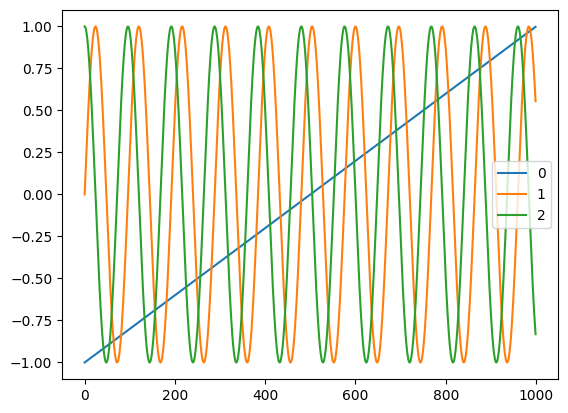

In [21]:
# Plot the feature columns

import pandas as pd

pd.DataFrame(X).plot()

### Without Covariates

Processing: 100%|██████████| [00:01<00:00]


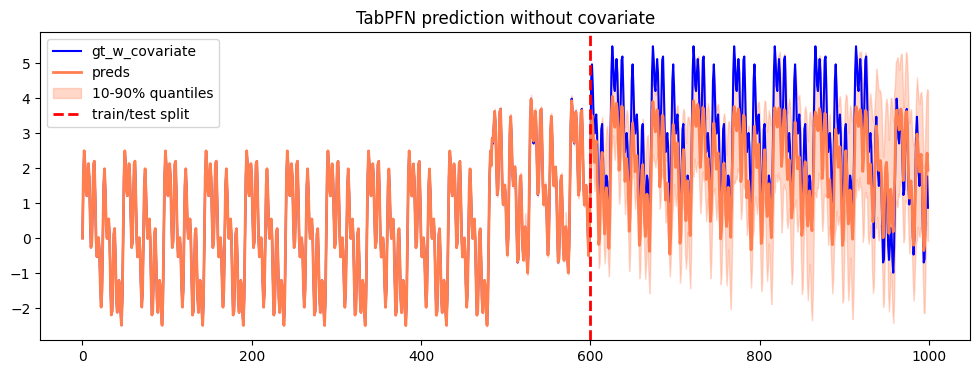

In [22]:
import matplotlib.pyplot as plt
from tabpfn_client import TabPFNRegressor

tabpfn = TabPFNRegressor()
tabpfn.fit(train_X, train_y)
full_preds = tabpfn.predict(test_X, output_type="main")

preds = full_preds["median"]
quantiles = full_preds["quantiles"]

quantiles_10 = quantiles[0]
quantiles_90 = quantiles[8]

plt.figure(figsize=(12, 4))
plt.title("TabPFN prediction without covariate")
# plt.plot(x, y_no_covariate, label='gt_wo_covariate', linestyle='--', color='gray')
plt.plot(x, test_y, label="gt_w_covariate", color="blue")
plt.plot(x, preds, label="preds", color="coral", linewidth=2)
plt.fill_between(
    x, quantiles_10, quantiles_90, alpha=0.3, label="10-90% quantiles", color="coral"
)
plt.axvline(
    x=x[N_TRAIN_TIMESTEPS],
    color="r",
    linestyle="--",
    linewidth=2,
    label="train/test split",
)
plt.legend(loc="upper left")
plt.show()

### With Covariates

Processing: 100%|██████████| [00:03<00:00]


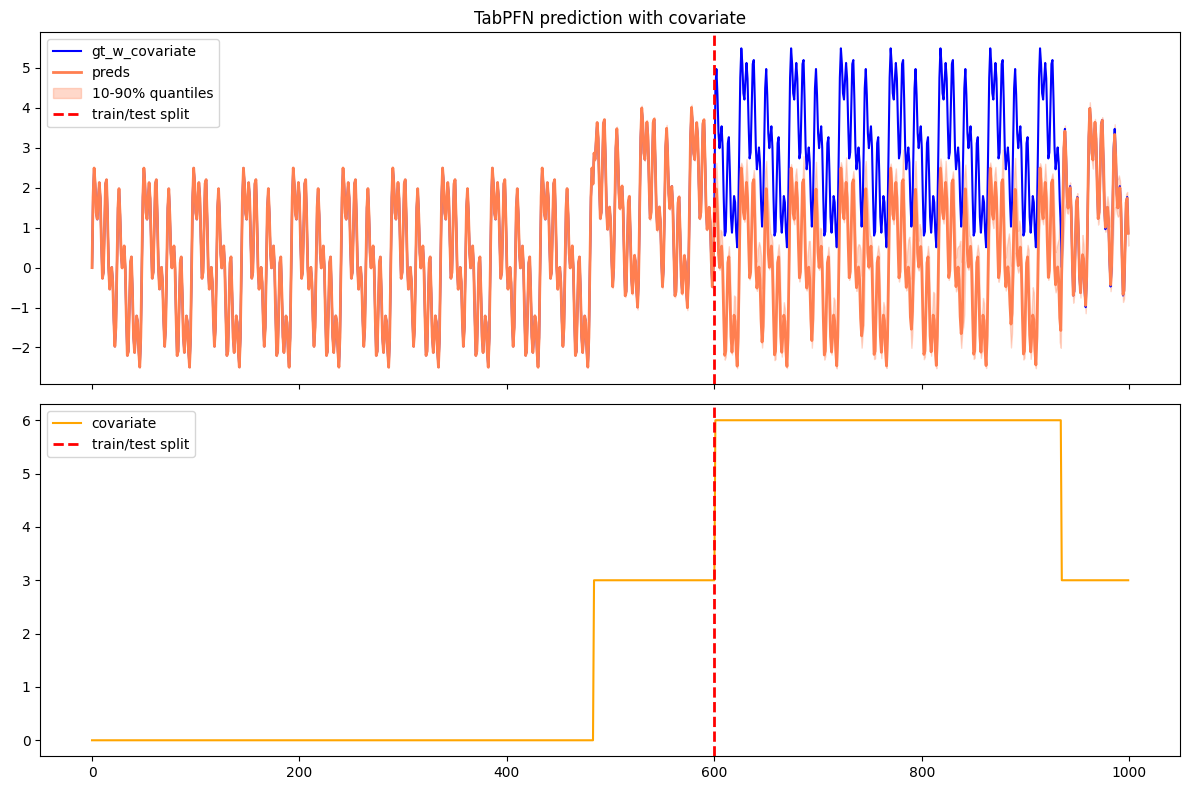

In [23]:
import matplotlib.pyplot as plt
from tabpfn_client import TabPFNRegressor

tabpfn = TabPFNRegressor()
tabpfn.fit(train_X_with_covariate, train_y)
full_preds = tabpfn.predict(test_X_with_covariate, output_type="main")
preds = full_preds["median"]
quantiles = full_preds["quantiles"]
quantiles_10 = quantiles[0]
quantiles_90 = quantiles[8]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Main plot
ax1.plot(x, test_y, label="gt_w_covariate", color="blue")
ax1.plot(x, preds, label="preds", color="coral", linewidth=2)
ax1.fill_between(
    x, quantiles_10, quantiles_90, alpha=0.3, label="10-90% quantiles", color="coral"
)

ax1.axvline(
    x=x[N_TRAIN_TIMESTEPS],
    color="r",
    linestyle="--",
    linewidth=2,
    label="train/test split",
)
ax1.set_title("TabPFN prediction with covariate")
ax1.legend(loc="upper left")

# Covariate subplot
ax2.plot(x, covariate, label="covariate", color="orange")
ax2.axvline(
    x=x[N_TRAIN_TIMESTEPS],
    color="r",
    linestyle="--",
    linewidth=2,
    label="train/test split",
)
ax2.legend()

plt.tight_layout()
plt.show()

In [24]:
quantiles.shape

(9, 1000)